<a href="https://colab.research.google.com/github/HanaeELMEKKI/COMP-6321-Assignment-2/blob/main/Question%201%20/Assignement2_Implementation_Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation Question 1**

dataset Kaggle link: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256?select=Data

In [25]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
from prettytable import PrettyTable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
!wget "https://raw.githubusercontent.com/HanaeELMEKKI/COMP-6321-Assignment-2/main/brain_tumors.zip"
!unzip "brain_tumors.zip";

--2023-11-13 01:19:37--  https://raw.githubusercontent.com/HanaeELMEKKI/COMP-6321-Assignment-2/main/brain_tumors.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62292733 (59M) [application/zip]
Saving to: ‘brain_tumors.zip’

brain_tumors.zip    100%[===================>]  59.41M   173MB/s    in 0.3s    

2023-11-13 01:19:37 (173 MB/s) - ‘brain_tumors.zip’ saved [62292733/62292733]

Archive:  brain_tumors.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating

In [3]:
path ="/content/Data"
n_classes = 4
default_num_epochs = 60
momentum =0.9
default_lr = 0.01
default_batch_size = 64
default_criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0') # if torch.cuda.is_available() else 'cpu'

**Statistics of the dataset**

In [4]:
# Calculation of the mean and std
transform_dict = {
                    'src': transforms.Compose([
                      transforms.ToTensor()])}

dataset = datasets.ImageFolder(root=path, transform=transform_dict['src'])

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

print(get_mean_and_std(dataset))

==> Computing mean and std..
(tensor([0.2106, 0.2106, 0.2106]), tensor([0.1903, 0.1903, 0.1903]))


**Pre-processing of the dataset**

In [5]:
transform_dict = {
                    'src': transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.2106, 0.2106, 0.2106],
                                            std=[0.1903, 0.1903, 0.1903]),
     ])}

data = datasets.ImageFolder(root=path, transform=transform_dict['src'])
dataset_size = len(data)

train_size = int((0.7)*dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(data, [train_size, test_size])

data_loader_train = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True, drop_last=False)
data_loader_test  = DataLoader(test_dataset, batch_size=default_batch_size, shuffle=True, drop_last=False)

**Training Function**

In [6]:
def train(model, train_loader, criterion, lr, epochs):
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)
    train_acc_epoch = []
    train_loss_epoch = []
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        training_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * inputs.size(0)
            training_corrects += torch.sum(preds == labels.data)
        train_loss = training_loss / len(train_loader.dataset)
        train_acc = training_corrects.double() / len(train_loader.dataset)
        train_acc_epoch.append(train_acc.item())
        train_loss_epoch.append(train_loss)
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, epochs, train_loss, train_acc))
    return train_acc_epoch, train_loss_epoch

**Train ResNet18 from scratch**

In [7]:
scratch_model = resnet18(pretrained=False)
scratch_model.to(device)
scratch_model.fc = torch.nn.Linear(scratch_model.fc.in_features, n_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
scratch_train_acc,scratch_train_loss = train(scratch_model, data_loader_train, default_criterion, default_lr, default_num_epochs)

Epoch [1/60], Loss: 1.4364, Accuracy: 0.33%
Epoch [2/60], Loss: 1.3220, Accuracy: 0.39%
Epoch [3/60], Loss: 1.1923, Accuracy: 0.46%
Epoch [4/60], Loss: 1.1925, Accuracy: 0.49%
Epoch [5/60], Loss: 1.1791, Accuracy: 0.49%
Epoch [6/60], Loss: 1.1171, Accuracy: 0.52%
Epoch [7/60], Loss: 1.1926, Accuracy: 0.47%
Epoch [8/60], Loss: 1.1112, Accuracy: 0.53%
Epoch [9/60], Loss: 1.0723, Accuracy: 0.54%
Epoch [10/60], Loss: 1.0747, Accuracy: 0.55%
Epoch [11/60], Loss: 1.1001, Accuracy: 0.52%
Epoch [12/60], Loss: 1.0390, Accuracy: 0.56%
Epoch [13/60], Loss: 1.1123, Accuracy: 0.51%
Epoch [14/60], Loss: 0.9982, Accuracy: 0.58%
Epoch [15/60], Loss: 1.0181, Accuracy: 0.57%
Epoch [16/60], Loss: 0.9880, Accuracy: 0.57%
Epoch [17/60], Loss: 0.9543, Accuracy: 0.62%
Epoch [18/60], Loss: 0.9760, Accuracy: 0.59%
Epoch [19/60], Loss: 0.9487, Accuracy: 0.60%
Epoch [20/60], Loss: 0.9815, Accuracy: 0.58%
Epoch [21/60], Loss: 0.9480, Accuracy: 0.60%
Epoch [22/60], Loss: 1.0241, Accuracy: 0.57%
Epoch [23/60], Loss

**Train ResNet18 pre-trained**

In [9]:
pretrained_model = resnet18(pretrained=True)
pretrained_model.to(device)
pretrained_model.fc = torch.nn.Linear(pretrained_model.fc.in_features, n_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [10]:
pretrain_train_acc,pretrain_train_loss = train(pretrained_model, data_loader_train, default_criterion, default_lr, default_num_epochs)

Epoch [1/60], Loss: 0.8650, Accuracy: 0.64%
Epoch [2/60], Loss: 0.5221, Accuracy: 0.80%
Epoch [3/60], Loss: 0.4826, Accuracy: 0.82%
Epoch [4/60], Loss: 0.4048, Accuracy: 0.86%
Epoch [5/60], Loss: 0.4562, Accuracy: 0.82%
Epoch [6/60], Loss: 0.3909, Accuracy: 0.85%
Epoch [7/60], Loss: 0.3413, Accuracy: 0.87%
Epoch [8/60], Loss: 0.3635, Accuracy: 0.86%
Epoch [9/60], Loss: 0.3074, Accuracy: 0.89%
Epoch [10/60], Loss: 0.3158, Accuracy: 0.88%
Epoch [11/60], Loss: 0.2963, Accuracy: 0.89%
Epoch [12/60], Loss: 0.3109, Accuracy: 0.88%
Epoch [13/60], Loss: 0.2896, Accuracy: 0.89%
Epoch [14/60], Loss: 0.2770, Accuracy: 0.90%
Epoch [15/60], Loss: 0.3138, Accuracy: 0.89%
Epoch [16/60], Loss: 0.2838, Accuracy: 0.89%
Epoch [17/60], Loss: 0.2648, Accuracy: 0.90%
Epoch [18/60], Loss: 0.2803, Accuracy: 0.89%
Epoch [19/60], Loss: 0.2558, Accuracy: 0.91%
Epoch [20/60], Loss: 0.2903, Accuracy: 0.89%
Epoch [21/60], Loss: 0.2628, Accuracy: 0.89%
Epoch [22/60], Loss: 0.2906, Accuracy: 0.89%
Epoch [23/60], Loss

**Plots utilities**

In [11]:
def plot_loss(train_loss):
  plt.plot(train_loss,  label='Training Loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss plot")
  plt.legend()
  plt.show()

In [12]:
def plot_accuracy(train_acc):
  plt.plot(train_acc, label='Training Accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy plot")
  plt.legend()

In [28]:
def classification_report(model, test_loader):
  all_true_labels = []
  all_predictions = []
  for inputs, labels in test_loader:
      with torch.no_grad():
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
      _, predictions = torch.max(outputs, 1)
      all_predictions.extend(predictions.cpu().numpy())
      all_true_labels.extend(labels.cpu().numpy())

  report = classification_report(all_true_labels, all_predictions, output_dict=True, zero_division = False)
  table = PrettyTable()
  table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
  for label, metrics in report.items():
      if label in ['accuracy', 'macro avg', 'weighted avg']:
          continue
      table.add_row([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

  print(f'Classification report: ', {table})
  accuracy = accuracy_score(all_true_labels, all_predictions)
  print(f'Test accuracy : {accuracy}%', accuracy)

**Comparison**

Scratch Model Perfromance:
1.2.2


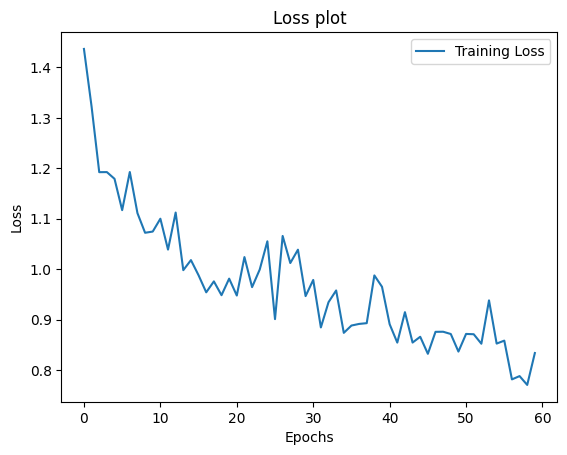

TypeError: ignored

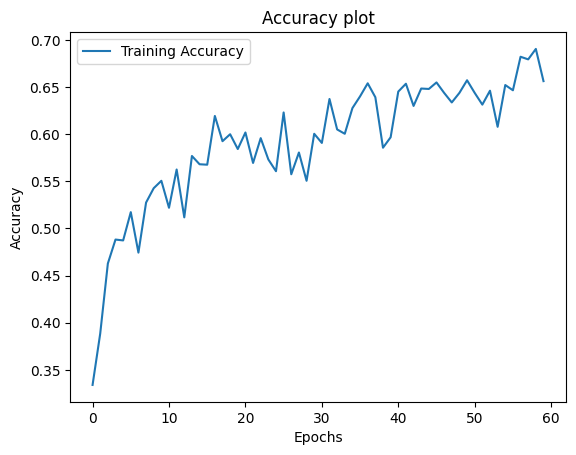

In [30]:
print("Scratch Model Perfromance:")
plot_loss(scratch_train_loss)
plot_accuracy(scratch_train_acc)
classification_report(scratch_model, data_loader_test)

Pre-trained Model Perfromance:


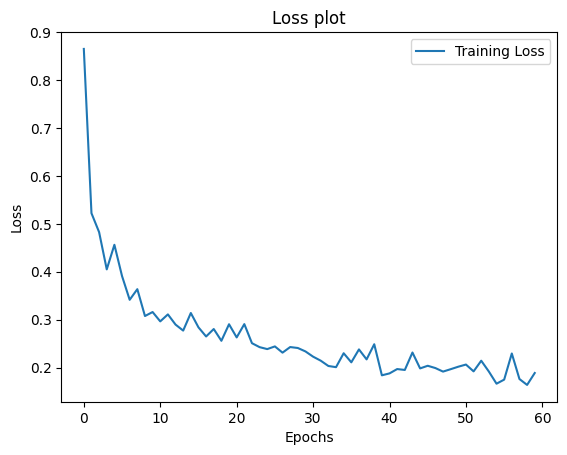

TypeError: ignored

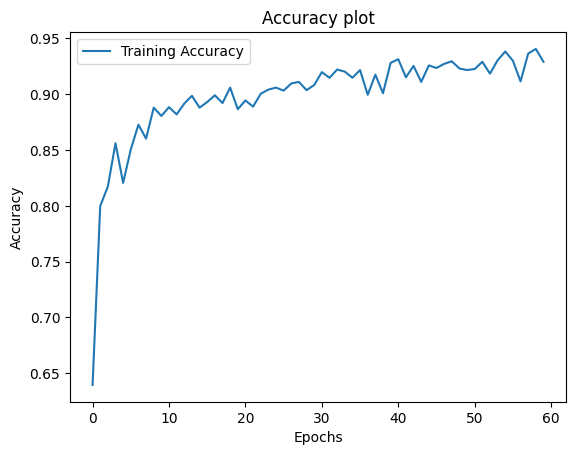

In [27]:
print("Pre-trained Model Perfromance:")
plot_loss(pretrain_train_loss)
plot_accuracy(pretrain_train_acc)
classification_report(pretrained_model, data_loader_test)